In [287]:
import os
import pandas as pd
import librosa
from librosa import display
import numpy as np
import IPython.display as ipd
from glob import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline 

labels = pd.read_csv(
    "../train.csv",
    names=['ID', 'Class']
)

In [143]:
classes = labels[1:].Class.unique()
class_nums = pd.factorize(classes)
cdict = { k:v for (k,v) in zip(class_nums[1], class_nums[0])}
inverted_cdict = dict([[v,k] for k,v in cdict.items()])
train_files = glob('{}/data/Train/*.wav'.format(os.path.abspath('../')))
cdict

{'siren': 0,
 'street_music': 1,
 'drilling': 2,
 'dog_bark': 3,
 'children_playing': 4,
 'gun_shot': 5,
 'engine_idling': 6,
 'air_conditioner': 7,
 'jackhammer': 8,
 'car_horn': 9}

In [180]:
TARGET_LEN = 88200
HZ_SLICE = 14

def data_to_spec(data):
    D = librosa.stft(data)
    return librosa.power_to_db(np.abs(D)**2, ref=np.median)

def data_to_mfcc(data):
    return librosa.feature.mfcc(data) 

def file_to_spec(filename):
    data, rate = librosa.load(filename)
    if data.shape[0] != TARGET_LEN: # handle short sounds
        data = extend_short_sounds(data)
    return data_to_spec(data)

def file_to_mfcc(filename):
    data, rate = librosa.load(filename)
    if data.shape[0] != TARGET_LEN: # handle short sounds
        data = extend_short_sounds(data)
    return data_to_mfcc(data)

def file_to_label(filename):
    fname = os.path.basename(filename)
    cid = fname.replace('.wav', '')
    classname = labels.loc[labels['ID'] == cid]
    return classname.values.tolist()[0][1] 

def show_file(filename):
    plt.title(file_to_label(filename))
    librosa.display.specshow(file_to_spec(filename), x_axis='time', y_axis='linear');
    plt.colorbar(); 
    
def extend_short_sounds(data):
    stretched = librosa.effects.time_stretch(data, rate=data.shape[0]/TARGET_LEN)
    return stretched[:TARGET_LEN:]

def drop_frequency_bands(data):
    return data[::HZ_SLICE,]

def show_progress(progress):
    if progress % 40:
        print('.', end="")
    else:
        print('.')

In [245]:
f = train_files[0]
ss = file_to_spec(f)
mm = file_to_mfcc(f)
print(ss.shape)
mm.shape

(1025, 173)


(20, 173)

In [246]:
def wav_to_stft(files, labels):
    info = []
    data_arr = []
    progress = 0
    for filename in files:
        d = file_to_mfcc(filename)
        #d = drop_frequency_bands(d)
        data_arr.append(d)
        if isinstance(labels, pd.DataFrame): 
            # labeled case
            info.append( file_to_label(filename) )
        else:                                
            # unlabled case
            info.append(filename)
        progress+=1
        show_progress(progress)
        #print(d.shape)
    return data_arr, info

# uncomment to calculate and save

#train_data, train_labels = wav_to_stft(train_files, labels)
#np.save('train_spec_mfcc2', train_data)
#np.save('train_label_mfcc2', train_labels)
print('done')

done


In [273]:
# Load the saved results
train_spec_load = np.load('./train_spec_mfcc.npy')
train_labels_load = np.load('./train_label_mfcc.npy')
train_spec_load.shape

def mean_mfcc_features(x):
    return x.mean(axis=2)

t = train_spec_load


train_spec = mean_mfcc_features(t)
train_spec.shape


(5428, 20)

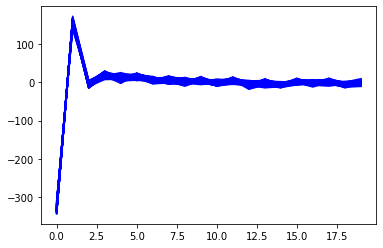

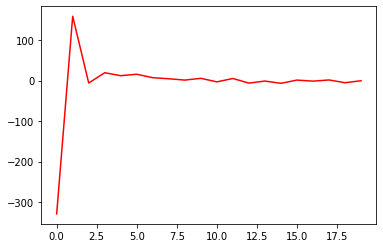

In [274]:

plt.plot(t[0], 'b')
plt.figure()
plt.plot(train_spec[0], 'r')

In [275]:
# split training and test data
from sklearn.model_selection import train_test_split

# convert my labels to numeric form
labels = np.array(list(map(lambda k: cdict[k], train_labels_load)))

train_data, test_data1, train_labels, test_labels1 = train_test_split(
    train_spec, 
    labels, 
    test_size=0.30, 
    random_state=42
)

# split test in to test/validation
validation_data, test_data, validation_labels, test_labels = train_test_split(
    test_data1, 
    test_labels1, 
    test_size=0.30, 
    random_state=42
)


print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)


(3799, 20)
(1140, 20)
(489, 20)


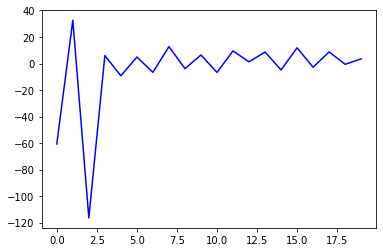

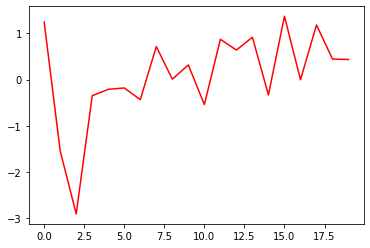

In [307]:
#train_data = train_data.reshape((train_data.shape[0], xx * yy))
#train_data = train_data.astype('float32')/255
#test_data = test_data.reshape((test_data.shape[0], xx * yy ))
#test_data = test_data.astype('float32')/255
#validation_data = validation_data.reshape((validation_data.shape[0], xx * yy ))
#validation_data = validation_data.astype('float32')/255

scaler = StandardScaler()
scaler.fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)
validation_scaled = scaler.transform(validation_data)

plt.plot(train_data[0], 'b-')
plt.figure()
plt.plot(train_scaled[0], 'r')

In [308]:
def build_model():
  model = Sequential([
    layers.Dense(512, activation=tf.nn.relu, input_shape=(20,),
                kernel_regularizer=regularizers.l1(0.001)),
    layers.Dense(256, activation=tf.nn.relu),
    layers.Dense(10, activation='softmax'),
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy',])
  return model
model = build_model();

history = model.fit(train_scaled, train_labels, epochs=120, validation_data=(validation_scaled, validation_labels))


Train on 3799 samples, validate on 1140 samples
Epoch 1/120
3799/3799 [==============================] - 1s 190us/sample - loss: 1.8467 - acc: 0.5546 - val_loss: 1.5663 - val_acc: 0.6298
Epoch 2/120
3799/3799 [==============================] - 0s 87us/sample - loss: 1.3635 - acc: 0.6962 - val_loss: 1.3119 - val_acc: 0.7281
Epoch 3/120
3799/3799 [==============================] - 0s 87us/sample - loss: 1.1502 - acc: 0.7539 - val_loss: 1.1843 - val_acc: 0.7456
Epoch 4/120
3799/3799 [==============================] - 0s 88us/sample - loss: 1.0084 - acc: 0.7963 - val_loss: 1.0640 - val_acc: 0.7719
Epoch 5/120
3799/3799 [==============================] - 0s 87us/sample - loss: 0.9077 - acc: 0.8192 - val_loss: 0.9734 - val_acc: 0.8000
Epoch 6/120
3799/3799 [==============================] - 0s 88us/sample - loss: 0.8257 - acc: 0.8429 - val_loss: 0.9059 - val_acc: 0.8140
Epoch 7/120
3799/3799 [==============================] - 0s 89us/sample - loss: 0.7551 - acc: 0.8571 - val_loss: 0.8727 - v

Epoch 118/120
3799/3799 [==============================] - 0s 87us/sample - loss: 0.1238 - acc: 0.9918 - val_loss: 0.5817 - val_acc: 0.9009
Epoch 119/120
3799/3799 [==============================] - 0s 86us/sample - loss: 0.1251 - acc: 0.9908 - val_loss: 0.6209 - val_acc: 0.8965
Epoch 120/120
3799/3799 [==============================] - 0s 87us/sample - loss: 0.1145 - acc: 0.9939 - val_loss: 0.5950 - val_acc: 0.8939


In [309]:
test_loss, test_acc = model.evaluate(test_scaled, test_labels)
test_acc

489/489 [==============================] - 0s 38us/sample - loss: 0.5042 - acc: 0.9223


0.9222904

In [310]:
#history
#model.save_weights('urban_sound_7_model')


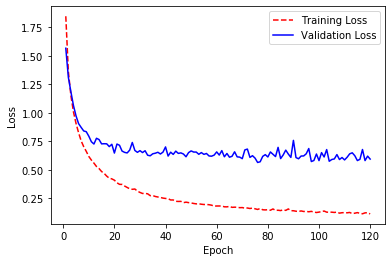

In [311]:
# Get training and test loss histories
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [312]:
# load up unlabeled test files
test_files = glob('{}/data/Test/*.wav'.format(os.path.abspath('../')))

In [313]:
# To predict, I'll have to put the audio through the same processing.  Let's start with 10
processed_wavs, file_names = wav_to_stft(test_files[:10], test_labels[:10])

train_spec = np.array(processed_wavs)
print(train_spec.shape)

# take the mean of each feature
train_spec = mean_mfcc_features(train_spec)

# scale
final = scaler.transform(train_spec)

predictions = model.predict(final)
predictions

..........(10, 20, 173)


array([[7.11515665e-01, 6.97197220e-06, 4.88287536e-04, 1.06421638e-09,
        1.42562528e-09, 2.15240344e-19, 1.24799311e-01, 1.63179308e-01,
        1.05580284e-05, 2.40576331e-12],
       [2.18411861e-03, 2.91020162e-02, 2.91006454e-08, 9.63750947e-03,
        9.59075868e-01, 2.10106196e-10, 3.98503033e-07, 1.37431880e-11,
        3.64618891e-09, 1.83013460e-09],
       [1.21510841e-01, 1.13132097e-01, 9.34460608e-04, 1.34084458e-02,
        1.96232405e-02, 1.79456450e-07, 1.42111450e-01, 5.81831217e-01,
        7.37439562e-03, 7.36689835e-05],
       [1.77341875e-09, 4.53320901e-08, 9.99997735e-01, 3.00448626e-08,
        2.09401787e-06, 3.34901830e-19, 1.05287779e-14, 2.70536327e-09,
        1.28564184e-12, 2.15548773e-25],
       [4.22079108e-11, 2.65968758e-09, 9.42563139e-10, 1.19144170e-04,
        9.99880791e-01, 9.40543199e-09, 1.30978450e-14, 3.45783277e-14,
        5.27197442e-17, 3.66403015e-08],
       [1.22901697e-11, 1.01207615e-05, 9.23961122e-03, 6.81008078e-06,
   

Results from CNN 

Model predicts 3957.wav is air_conditioner

Model predicts 2146.wav is children_playing

Model predicts 3922.wav is air_conditioner

Model predicts 4090.wav is drilling

Model predicts 3245.wav is children_playing

Model predicts 3457.wav is jackhammer

Model predicts 2716.wav is jackhammer

Model predicts 2298.wav is jackhammer

Model predicts 4727.wav is street_music

Model predicts 4777.wav is jackhammer


In [314]:
for i in range(len(file_names)):
    p = np.argmax(predictions[i])
    print("Model predicts {} is {}\n".format(
        os.path.basename(file_names[i]), inverted_cdict[p])
    )
    

Model predicts 3957.wav is siren

Model predicts 2146.wav is children_playing

Model predicts 3922.wav is air_conditioner

Model predicts 4090.wav is drilling

Model predicts 3245.wav is children_playing

Model predicts 3457.wav is jackhammer

Model predicts 2716.wav is jackhammer

Model predicts 2298.wav is drilling

Model predicts 4727.wav is jackhammer

Model predicts 4777.wav is jackhammer



In [319]:
fname = file_names[0]
print(os.path.basename(fname))
ipd.Audio(fname)

3957.wav
